In [1]:
import pandas as pd

def load_and_concatenate_csv(file_list):
    """
    Loads multiple CSV files and concatenates them into a single DataFrame.
    
    Parameters:
    file_list (list of str): List of CSV file paths.
    
    Returns:
    pd.DataFrame: Concatenated DataFrame with all data from the files.
    """
    df_list = []
    
    for file in file_list:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no files were loaded

# Example usage:
files = [
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\raise eybrows quick + garbage_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\raise eyebrows and hold_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\reading outloud-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\smiling-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\squinting-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\blinks_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye gaze left right 1_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye gaze left right 2_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye movements up down-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\noise-labeled-af.csv"
]

combined_df = load_and_concatenate_csv(files)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
combined_df = combined_df.drop(columns=['timestamp'])
# Ensure 'label' column is a string type to avoid comparison issues
combined_df['label'] = combined_df['label'].astype(str)

# Apply the relabeling function only to the 'label' column
combined_df['label'] = combined_df['label'].apply(lambda x: 1 if x.lower() == 'blink' else 0)

In [3]:
# Count total rows (samples)
total_samples = len(combined_df)

# Count the number of blinks
num_blinks = combined_df['label'].sum()

# Calculate percentage of blinks
blink_percentage = (num_blinks / total_samples) * 100 if total_samples > 0 else 0

print(f"Percentage of blinks in the dataset: {blink_percentage:.2f}%")


Percentage of blinks in the dataset: 3.63%


In [4]:
import numpy as np

# Find the indices where blinks occur
blink_indices = np.where(combined_df['label'].values == 1)[0]

# Identify consecutive sequences
if len(blink_indices) > 0:
    blink_durations = []
    start = blink_indices[0]
    
    for i in range(1, len(blink_indices)):
        if blink_indices[i] != blink_indices[i - 1] + 1:  # If not consecutive
            blink_durations.append(blink_indices[i - 1] - start + 1)
            start = blink_indices[i]  # Start a new blink event

    # Add the last detected blink duration
    blink_durations.append(blink_indices[-1] - start + 1)

    # Compute average blink length and standard deviation
    avg_blink_length = np.mean(blink_durations)
    std_blink_length = np.std(blink_durations)

    print(f"Average blink duration: {avg_blink_length:.2f} samples")
    print(f"Standard deviation of blink duration: {std_blink_length:.2f} samples")
else:
    print("No blinks found in the dataset.")


Average blink duration: 152.89 samples
Standard deviation of blink duration: 25.66 samples


In [5]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Parameters
num_channels = 16
window_size = 150
step_size = 30
image_height = 25
min_val, max_val = -50, 50
blink_threshold = 0.8  

# Function to create overlapping windows from each file
def create_windows(emg_data, labels, window_size, step_size, blink_threshold):
    """Generates overlapping windows from EMG data."""
    X, y, indices = [], [], []
    num_samples = len(emg_data)
    
    for start in range(0, num_samples - window_size, step_size):
        window_data = emg_data[start:start + window_size, :]
        window_labels = labels[start:start + window_size]
        
        blink_ratio = np.mean(window_labels == 1)
        window_label = 1 if blink_ratio >= blink_threshold else 0
        
        X.append(window_data)
        y.append(window_label)
        indices.append(start)
    
    return np.array(X), np.array(y), np.array(indices)

# Initialize datasets
train_data, val_data, test_data = [], [], []
train_labels, val_labels, test_labels = [], [], []

for file in files:
    df = pd.read_csv(file)
    df['label'] = df['label'].astype(str)
    df['label'] = df['label'].apply(lambda x: 1 if x.lower() == 'blink' else 0)
    df = df.drop(columns=['timestamp'])

    emg_data = df.iloc[:, :-1].values
    labels = df['label'].values

    X_windows, y_windows, window_indices = create_windows(emg_data, labels, window_size, step_size, blink_threshold)
    
    if "blinks_labeled_af.csv" in file:
        blink_indices = np.where(y_windows == 1)[0]
        
        train_end_idx = blink_indices[int(0.6 * len(blink_indices))+4]  # 60% blinks for Train
        val_end_idx = blink_indices[int(0.8 * len(blink_indices))+4]  # 80% blinks for Validation
        
        for i, idx in enumerate(window_indices):
            if i <= train_end_idx:
                train_data.append(X_windows[i])
                train_labels.append(y_windows[i])
            elif i <= val_end_idx:
                val_data.append(X_windows[i])
                val_labels.append(y_windows[i])
            else:
                test_data.append(X_windows[i])
                test_labels.append(y_windows[i])
    else:
        blink_windows = np.where(y_windows == 1)[0]
        assigned_splits = {}
        
        for bw in blink_windows:
            if bw not in assigned_splits:
                split_choice = random.choice(["train", "val", "test"])
                assigned_splits[bw] = split_choice
            else:
                split_choice = assigned_splits[bw]
            
            start_idx = max(0, bw - 5)
            end_idx = min(len(X_windows), bw + 6)
            
            for i in range(start_idx, end_idx):
                if split_choice == "train":
                    train_data.append(X_windows[i])
                    train_labels.append(y_windows[i])
                elif split_choice == "val":
                    val_data.append(X_windows[i])
                    val_labels.append(y_windows[i])
                else:
                    test_data.append(X_windows[i])
                    test_labels.append(y_windows[i])
        
        # Ensure remaining indices exclude assigned blink regions
        assigned_indices = set()
        for bw in blink_windows:
            assigned_indices.update(range(max(0, bw - 5), min(len(X_windows), bw + 6)))
        remaining_indices = list(set(range(len(X_windows))) - assigned_indices)
        
        num_train = int(0.6 * len(remaining_indices))
        num_val = int(0.2 * len(remaining_indices))
        
        train_data.extend([X_windows[i] for i in remaining_indices[:num_train]])
        train_labels.extend([y_windows[i] for i in remaining_indices[:num_train]])
        val_data.extend([X_windows[i] for i in remaining_indices[num_train+4:num_train + num_val]])
        val_labels.extend([y_windows[i] for i in remaining_indices[num_train+4:num_train + num_val]])
        test_data.extend([X_windows[i] for i in remaining_indices[num_train + num_val+4:]])
        test_labels.extend([y_windows[i] for i in remaining_indices[num_train + num_val+4:]])

# Convert lists to numpy arrays
X_train, y_train = np.array(train_data), np.array(train_labels)
X_val, y_val = np.array(val_data), np.array(val_labels)
X_test, y_test = np.array(test_data), np.array(test_labels)

print(f"Final Windows: Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)})")


Final Windows: Train (6268), Validation (2020), Test (2150)


In [6]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight


# Convert EMG signals to images
def normalize_and_convert_to_image(signal):
    """ Converts EMG window to an image of size (25, 150). """
    normalized_signal = (signal - min_val) / (max_val - min_val)
    normalized_signal = np.clip(normalized_signal, 0, 1)
    image = np.zeros((image_height, window_size))
    for t in range(window_size):
        pixel_y = int(normalized_signal[t] * (image_height - 1))
        image[pixel_y, t] = 1
    return image

# Convert each window to an image for each channel
X_train_images = np.zeros((len(X_train), num_channels, image_height, window_size, 1), dtype=np.float32)
X_val_images = np.zeros((len(X_val), num_channels, image_height, window_size, 1), dtype=np.float32)
X_test_images = np.zeros((len(X_test), num_channels, image_height, window_size, 1), dtype=np.float32)

for i in range(len(X_train)):
    for ch in range(num_channels):
        X_train_images[i, ch, :, :, 0] = normalize_and_convert_to_image(X_train[i, :, ch])

for i in range(len(X_val)):
    for ch in range(num_channels):
        X_val_images[i, ch, :, :, 0] = normalize_and_convert_to_image(X_val[i, :, ch])

for i in range(len(X_test)):
    for ch in range(num_channels):
        X_test_images[i, ch, :, :, 0] = normalize_and_convert_to_image(X_test[i, :, ch])

# Memory-efficient oversampling (batch-wise)
def batch_oversample(X, y, batch_size=1000):
    """Performs oversampling in batches only if multiple classes exist."""
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = [], []

    # Shuffle to avoid consecutive same-class windows
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]
    
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        X_batch = X[start:end].reshape(end - start, -1)  # Flatten batch
        y_batch = y[start:end]

        # Apply oversampling only if there are at least 2 classes
        if len(np.unique(y_batch)) > 1:
            X_batch_res, y_batch_res = oversampler.fit_resample(X_batch, y_batch)
            X_resampled.append(X_batch_res.reshape(-1, num_channels, image_height, window_size, 1))
            y_resampled.append(y_batch_res)
        else:
            # If only one class, append as is
            X_resampled.append(X_batch.reshape(-1, num_channels, image_height, window_size, 1))
            y_resampled.append(y_batch)

    return np.concatenate(X_resampled, axis=0), np.concatenate(y_resampled, axis=0)

# Apply batch-wise oversampling
X_train_resampled, y_train_resampled = batch_oversample(X_train_images, y_train, batch_size=2000)

# Convert to list format for multi-channel CNN
X_train_list = [X_train_resampled[:, ch, :, :, :] for ch in range(num_channels)]
X_val_list = [X_val_images[:, ch, :, :, :] for ch in range(num_channels)]
X_test_list = [X_test_images[:, ch, :, :, :] for ch in range(num_channels)]

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Training data shape: {X_train_resampled.shape}, Labels shape: {y_train_resampled.shape}")
print(f"Class weights: {class_weight_dict}")


Training data shape: (12342, 16, 25, 150, 1), Labels shape: (12342,)
Class weights: {0: 1.0, 1: 1.0}


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model Parameters
input_shape = (image_height, window_size, 1)  # Each input image shape (100x150, 1 channel)
num_classes = 2  # Binary classification (Blink or No Blink)

def build_multi_channel_cnn():
    """CNN Model for Multi-Channel EMG-Based Blink Detection"""
    inputs = [keras.Input(shape=input_shape) for _ in range(num_channels)]  # 16 separate inputs

    conv_blocks = []
    for inp in inputs:
        x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inp)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        conv_blocks.append(x)

    # Merge outputs from all channels
    merged = layers.Concatenate()(conv_blocks)
    x = layers.Dense(128, activation="relu")(merged)
    x = layers.Dropout(0.3)(x)  # Reduce overfitting
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Create the model
multi_channel_cnn = build_multi_channel_cnn()
multi_channel_cnn.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 25, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 25, 150, 1)  0           []                               
                                ]                                                             

 max_pooling2d (MaxPooling2D)   (None, 12, 75, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 75, 16)  0           ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 12, 75, 16)  0           ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 75, 16)  0           ['conv2d_6[0][0]']               
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 12, 75, 16)  0           ['conv2d_8[0][0]']               
                                                                                                  
 max_pooli

 max_pooling2d_9 (MaxPooling2D)  (None, 6, 37, 32)   0           ['conv2d_9[0][0]']               
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 6, 37, 32)   0           ['conv2d_11[0][0]']              
 )                                                                                                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 6, 37, 32)   0           ['conv2d_13[0][0]']              
 )                                                                                                
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 6, 37, 32)   0           ['conv2d_15[0][0]']              
 )                                                                                                
          

                                                                                                  
 dense (Dense)                  (None, 128)          14549120    ['concatenate[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dropout[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 2)            130         ['dropout_1[0][0]']              
          

In [8]:
# Train the CNN with memory-efficient data loading
history = multi_channel_cnn.fit(
    X_train_list, y_train_resampled,
    epochs=1, batch_size=32,
    validation_data=(X_val_list, y_val),
    class_weight=class_weight_dict  # Handles any remaining imbalance
)

386/386 [==============================] - 199s 508ms/step - loss: 0.0519 - accuracy: 0.9831 - val_loss: 0.0157 - val_accuracy: 0.9950


In [9]:
# Evaluate on test set
test_loss, val_acc = multi_channel_cnn.evaluate(X_val_list, y_val)
print(f"Test Accuracy: {val_acc:.4f}")

64/64 [==============================] - 7s 115ms/step - loss: 0.0157 - accuracy: 0.9950
Test Accuracy: 0.9950


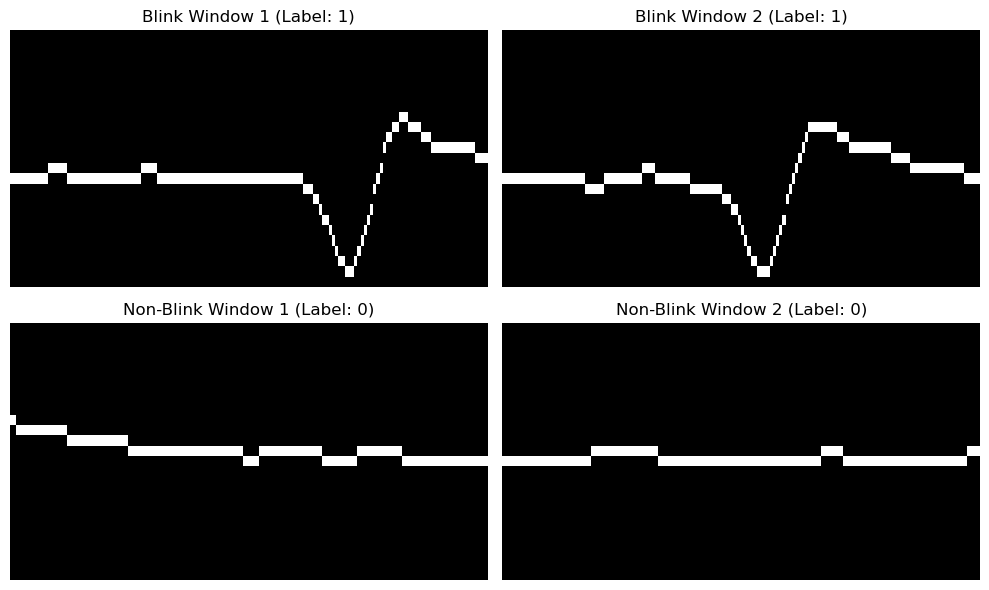

In [10]:
import matplotlib.pyplot as plt

# Plot 2 windows labeled 1 and 2 labeled 0
blink_indices = np.where(y_train_resampled == 1)[0][:2]
non_blink_indices = np.where(y_train_resampled == 0)[0][:2]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, idx in enumerate(blink_indices):
    ax = axes[0, i]
    ax.imshow(X_train_resampled[idx, 0, :, :, 0], cmap='gray', aspect='auto')  # Show first channel
    ax.set_title(f"Blink Window {i+1} (Label: 1)")
    ax.axis('off')

for i, idx in enumerate(non_blink_indices):
    ax = axes[1, i]
    ax.imshow(X_train_resampled[idx, 0, :, :, 0], cmap='gray', aspect='auto')  # Show first channel
    ax.set_title(f"Non-Blink Window {i+1} (Label: 0)")
    ax.axis('off')

plt.tight_layout()
plt.show()